<a href="https://colab.research.google.com/github/Camouflage10/disease-spread-model/blob/Camouflage10-bagging/disease_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.metrics import confusion_matrix, recall_score, precision_score
import seaborn as sn
import json
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor, BaggingClassifier
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error, accuracy_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, KFold


In [6]:
from matplotlib import text
x = pd.read_csv('train_x.csv')
y = pd.read_csv('dengue_labels_train.csv')
y=y.drop(columns=['city','year','weekofyear'])
test =pd.read_csv('test.csv')


x['year']=x['year'].astype(int)
x['city'].replace(['sj', 'iq'],[0, 1], inplace=True)
x[['year2', 'month', 'day']] = x['week_start_date'].str.split('-', expand=True)
x['month']=x['month'].astype(int)
x['day']=x['day'].astype(int)
x=x.drop(columns=['year2','week_start_date'])
test_removed=test[['city', 'year', 'week_start_date']]
test=test.drop(columns=['city', 'year', 'week_start_date'])
print(len(x))
print(len(y))
x.isna().sum()

1456
1456


Unnamed: 0                               0
weekofyear                               0
ndvi_ne                                  0
ndvi_nw                                  0
ndvi_se                                  0
ndvi_sw                                  0
reanalysis_air_temp_k                    0
reanalysis_avg_temp_k                    0
reanalysis_dew_point_temp_k              0
reanalysis_max_air_temp_k                0
reanalysis_min_air_temp_k                0
reanalysis_relative_humidity_percent     0
reanalysis_specific_humidity_g_per_kg    0
reanalysis_tdtr_k                        0
station_avg_temp_c                       0
station_diur_temp_rng_c                  0
station_min_temp_c                       0
city                                     0
year                                     0
month                                    0
day                                      0
dtype: int64

In [7]:
#tremove features with a corrilation of less than abs(mincorr)
x['total_cases']=y['total_cases']
minCorr=.2
corrMatrix = x.corr()
lastCol=corrMatrix['total_cases']
x=x.drop(columns=['total_cases'])
print(lastCol)
features=list(lastCol.loc[abs(lastCol) > minCorr].index)
features.remove('total_cases')
print(features)
x=x[features]
corrMatrix = x.corr()
for col in x.columns:
  print(col+":  "+str(x[col].isna().sum()))

Unnamed: 0                              -0.333340
weekofyear                               0.216452
ndvi_ne                                 -0.210937
ndvi_nw                                 -0.184179
ndvi_se                                 -0.232385
ndvi_sw                                 -0.249576
reanalysis_air_temp_k                    0.258385
reanalysis_avg_temp_k                    0.146057
reanalysis_dew_point_temp_k              0.135880
reanalysis_max_air_temp_k               -0.190789
reanalysis_min_air_temp_k                0.318676
reanalysis_relative_humidity_percent    -0.132312
reanalysis_specific_humidity_g_per_kg    0.124578
reanalysis_tdtr_k                       -0.278156
station_avg_temp_c                       0.113804
station_diur_temp_rng_c                 -0.235323
station_min_temp_c                       0.259204
city                                    -0.292624
year                                    -0.306806
month                                    0.215737


In [8]:

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33)


In [9]:

#X, y = x_train.iloc[:,:-1],y_train.iloc[:,-1]
df=pd.DataFrame()
df['target']=y_test
#bagging model

bag = BaggingRegressor()
#Setting values for the parameters
n_estimators = [100, 300, 500]
#max_depth = [5, 10, 15, 25, 30]
max_features = [1, 5, 8]

#Creating a dictionary for the hyper parameters
hyperbag = dict(n_estimators = n_estimators, 
              max_features = max_features)

#Applying GridSearchCV to get the best value for hyperparameters
gridbag = GridSearchCV(bag, hyperbag, cv = 3, verbose = 1, n_jobs = -1)
bestbag = gridbag.fit(x_train, y_train)
bestbag.fit(x_train, y_train)
preds = bestbag.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
df['pred']=preds
#scoring the model
score = bestbag.score(x_train, y_train)
print("Training Score: ", score)
#MSE and RMSE
preds = [round(value) for value in preds]
mse = mean_squared_error(y_test, preds)
print("MSE: %.2f" % mse)
rmse = np.sqrt(mean_squared_error(y_test, preds))
mae= mean_absolute_error(y_test,preds)
print("RMSE: %f" % (rmse))
print("MaE: %f" % (mae))

#accuracy score round preds
round_preds=[round(num) for num in preds]
accuracy = accuracy_score(y_test, round_preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

df

Fitting 3 folds for each of 9 candidates, totalling 27 fits


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


Fitting 3 folds for each of 9 candidates, totalling 27 fits


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


Training Score:  0.9578489176806239
MSE: 474.80
RMSE: 21.790011
MaE: 11.478170
Accuracy: 3.74%


,target,pred
247,46,37.310
360,11,14.866
643,6,40.888
935,5,10.234
1318,11,13.552
...,...,...
450,68,62.210
23,33,54.758
471,20,15.242
841,4,22.440


In [10]:
from sklearn.ensemble import RandomForestRegressor

bag = RandomForestRegressor()


#Creating a dictionary for the hyper parameters
grid_params={'n_estimators': [100,200],'max_features':['sqrt', 'log2', None]}

#Applying GridSearchCV to get the best value for hyperparameters
gridbag = GridSearchCV(bag, grid_params, cv = 3, verbose = 1, n_jobs = -1)
bestbag = gridbag.fit(x_train, y_train)
bestbag.fit(x_train, y_train)
preds = bestbag.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
df['pred']=preds
#scoring the model
score = bestbag.score(x_train, y_train)
print("Training Score: ", score)
#MSE and RMSE
preds = [round(value) for value in preds]
mse = mean_squared_error(y_test, preds)
print("MSE: %.2f" % mse)
rmse = np.sqrt(mean_squared_error(y_test, preds))
mae = mean_absolute_error(y_test,preds)
print("RMSE: %f" % (rmse))
print("MaE: %f" % (mae))

#accuracy score round preds
round_preds=[round(num) for num in preds]
accuracy = accuracy_score(y_test, round_preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Fitting 3 folds for each of 6 candidates, totalling 18 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Fitting 3 folds for each of 6 candidates, totalling 18 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Training Score:  0.9580782394808042
MSE: 535.13
RMSE: 23.132808
MaE: 12.033264
Accuracy: 4.99%


In [11]:
#create metrics.json (optional metrics.txt also)
value = {
        "rmse": rmse,
        "mae": mae
    }
with open('metrics.json', 'w') as outfile:
  outfile.write(json.dumps(value))

In [12]:
preds=np.array(preds)
y_test=np.array(y_test)
print(preds.shape)
y_test=y_test.reshape(preds.shape)
print(y_test.shape)
error=y_test-preds
print(error.shape)

(481,)
(481,)
(481,)


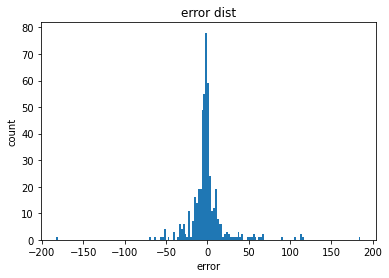

In [13]:
#visualization to see if it looks like it matches

#error=error.reshape(error.shape[0]*error.shape[1],1)
x_ax = range(len(y_test))
plt.tight_layout()
fig1 = plt.gcf()
plt.hist(error, bins='auto')
plt.title('error dist')
plt.xlabel('error')
plt.ylabel('count')
plt.show()

#create a graph called stats.png
fig1.savefig('stats.png', dpi=100)

In [14]:
#submit predictions for test
def submit(model, test):
  pred=model.predict(x)

In [19]:
print(x_test)

      Unnamed: 0  weekofyear   ndvi_ne   ndvi_se   ndvi_sw  \
247          247         4.0  0.051750  0.177229  0.134071   
360          360        14.0  0.134330  0.198317  0.191683   
643          643        37.0  0.033000  0.231971  0.239957   
935          935        17.0 -0.037000  0.077314  0.090586   
1318        1318        45.0  0.333457  0.246900  0.331129   
...          ...         ...       ...       ...       ...   
450          450        52.0  0.060567  0.157150  0.098187   
23            23        41.0  0.171150  0.179467  0.157717   
471          471        20.0  0.084118  0.194471  0.169157   
841          841        26.0  0.103500  0.133871  0.122943   
212          212        21.0  0.117800  0.208471  0.208486   

      reanalysis_air_temp_k  reanalysis_min_air_temp_k  reanalysis_tdtr_k  \
247              297.592857                      295.0           3.628571   
360              297.692857                      295.5           2.685714   
643              301.222

In [36]:
#submittable CSV file for predictions
pred = bestbag.predict(x_test)
submition=pd.DataFrame(x_test['year'])
submition['weekofyear']=x_test['weekofyear']
submition['city']=x_test['city']
submition['total_cases']=pred
submition.sort_values(["year","weekofyear"],axis=0, ascending=True, inplace=True, na_position='first')
submition.to_csv('submition.csv')